# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/XHT2c8jT3Bc)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sun May  5 22:21:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [2]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 325 (delta 158), reused 155 (delta 155), pack-reused 109
Receiving objects: 100% (325/325), 2.23 MiB | 7.31 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.1 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [3]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [4]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [5]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 May  9 18:37 .
drwxr-xr-x 1 root root      4096 May  9 18:36 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Download example data

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

In [ ]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [ ]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"

## Detection with pre-trained COCO model

### gelan-c

In [ ]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 467 layers, 25472640 parameters, 0 gradients, 102.8 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 handbag, 235.8ms
Speed: 0.6ms pre-process, 235.8ms inference, 704.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

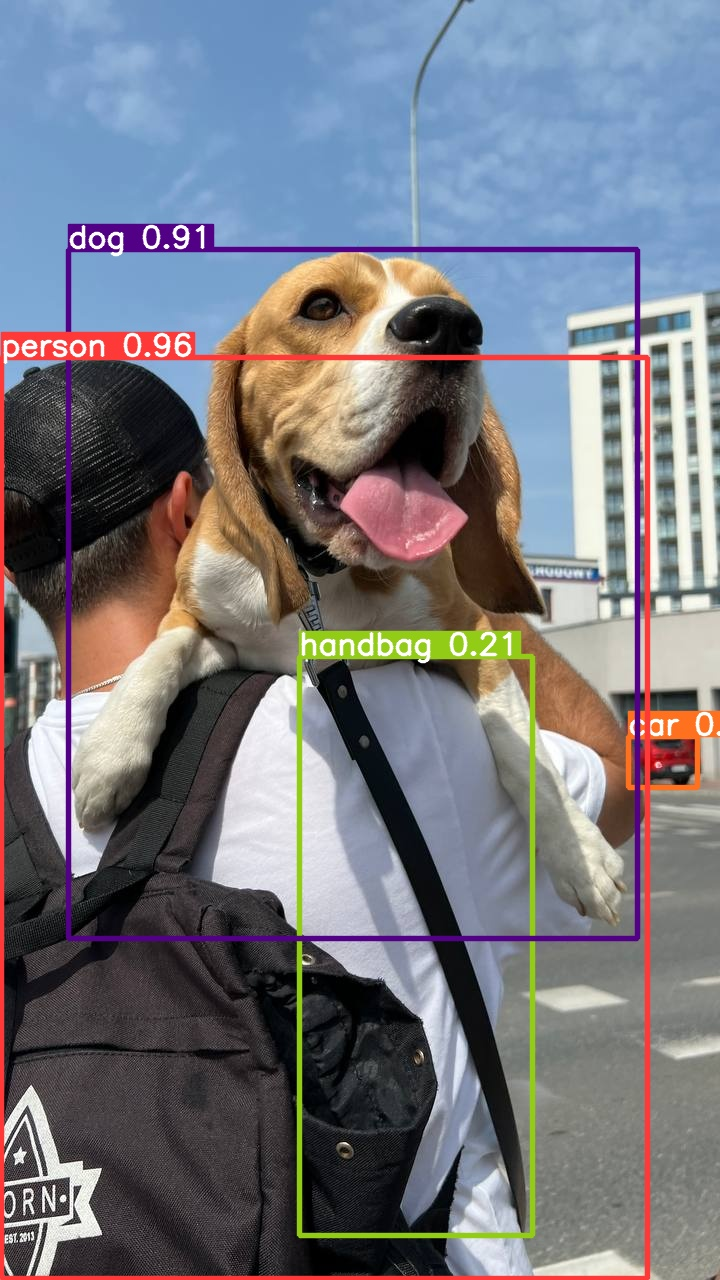

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp/dog.jpeg", width=600)

## yolov9-e

In [ ]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 1119 layers, 69470144 parameters, 0 gradients, 244.0 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1 handbag, 169.4ms
Speed: 0.5ms pre-process, 169.4ms inference, 489.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


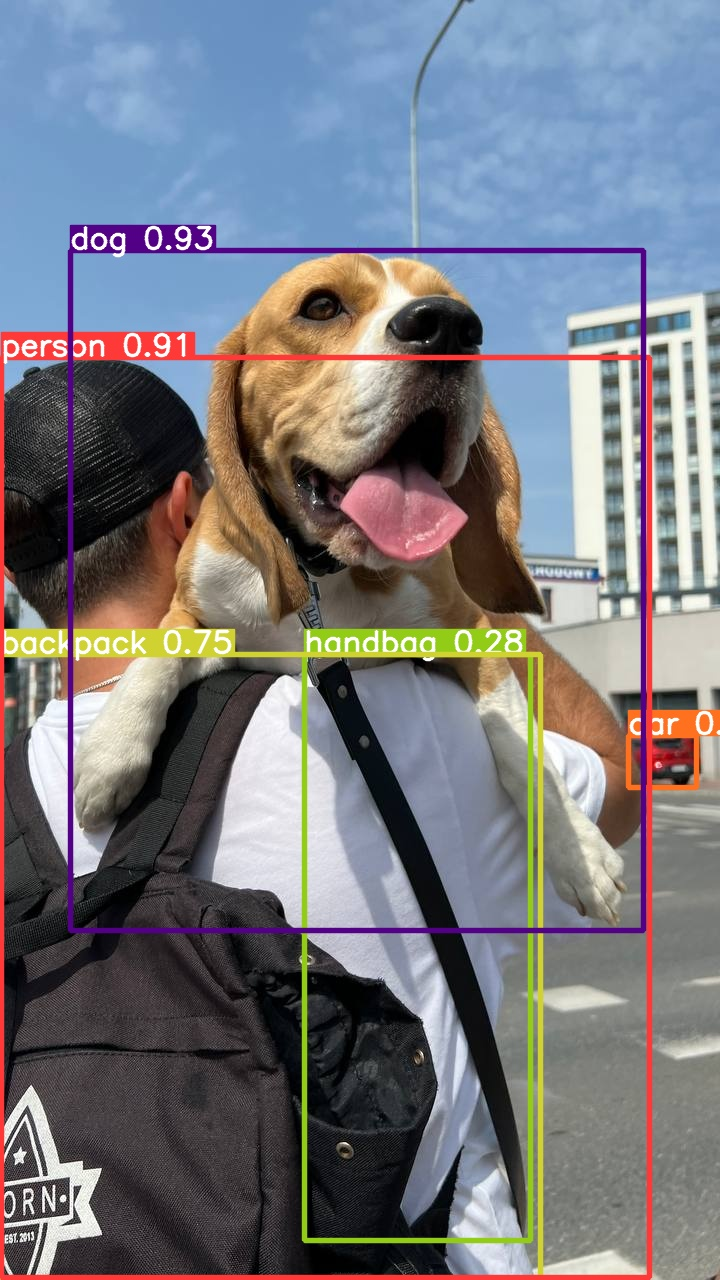

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp2/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [6]:
%cd {HOME}/yolov9

/content/yolov9


In [7]:
from roboflow import Roboflow

rf = Roboflow(api_key="mgyYYQWIMNNPZFKv4VfJ")
project = rf.workspace("computer-vision-6p7fp").project("aircraft-object-detection")
version = project.version(4)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Aircraft-Object-Detection-4 in yolov9:: 100%|██████████| 17062/17062 [00:01<00:00, 8745.11it/s]


## Train Custom Model

In [8]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 20 --img 256 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-05-09 18:38:12.437444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 18:38:12.437498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 18:38:12.438896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 18:38:13.503611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/Aircraft-Object-Detection-4/data.yaml, hyp=hyp.scratch-high.yaml, epochs=20, batch_size=16, imgsz=256, rect=False, resume=False,

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [9]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1715279894.302f42fd6bc2.1170.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


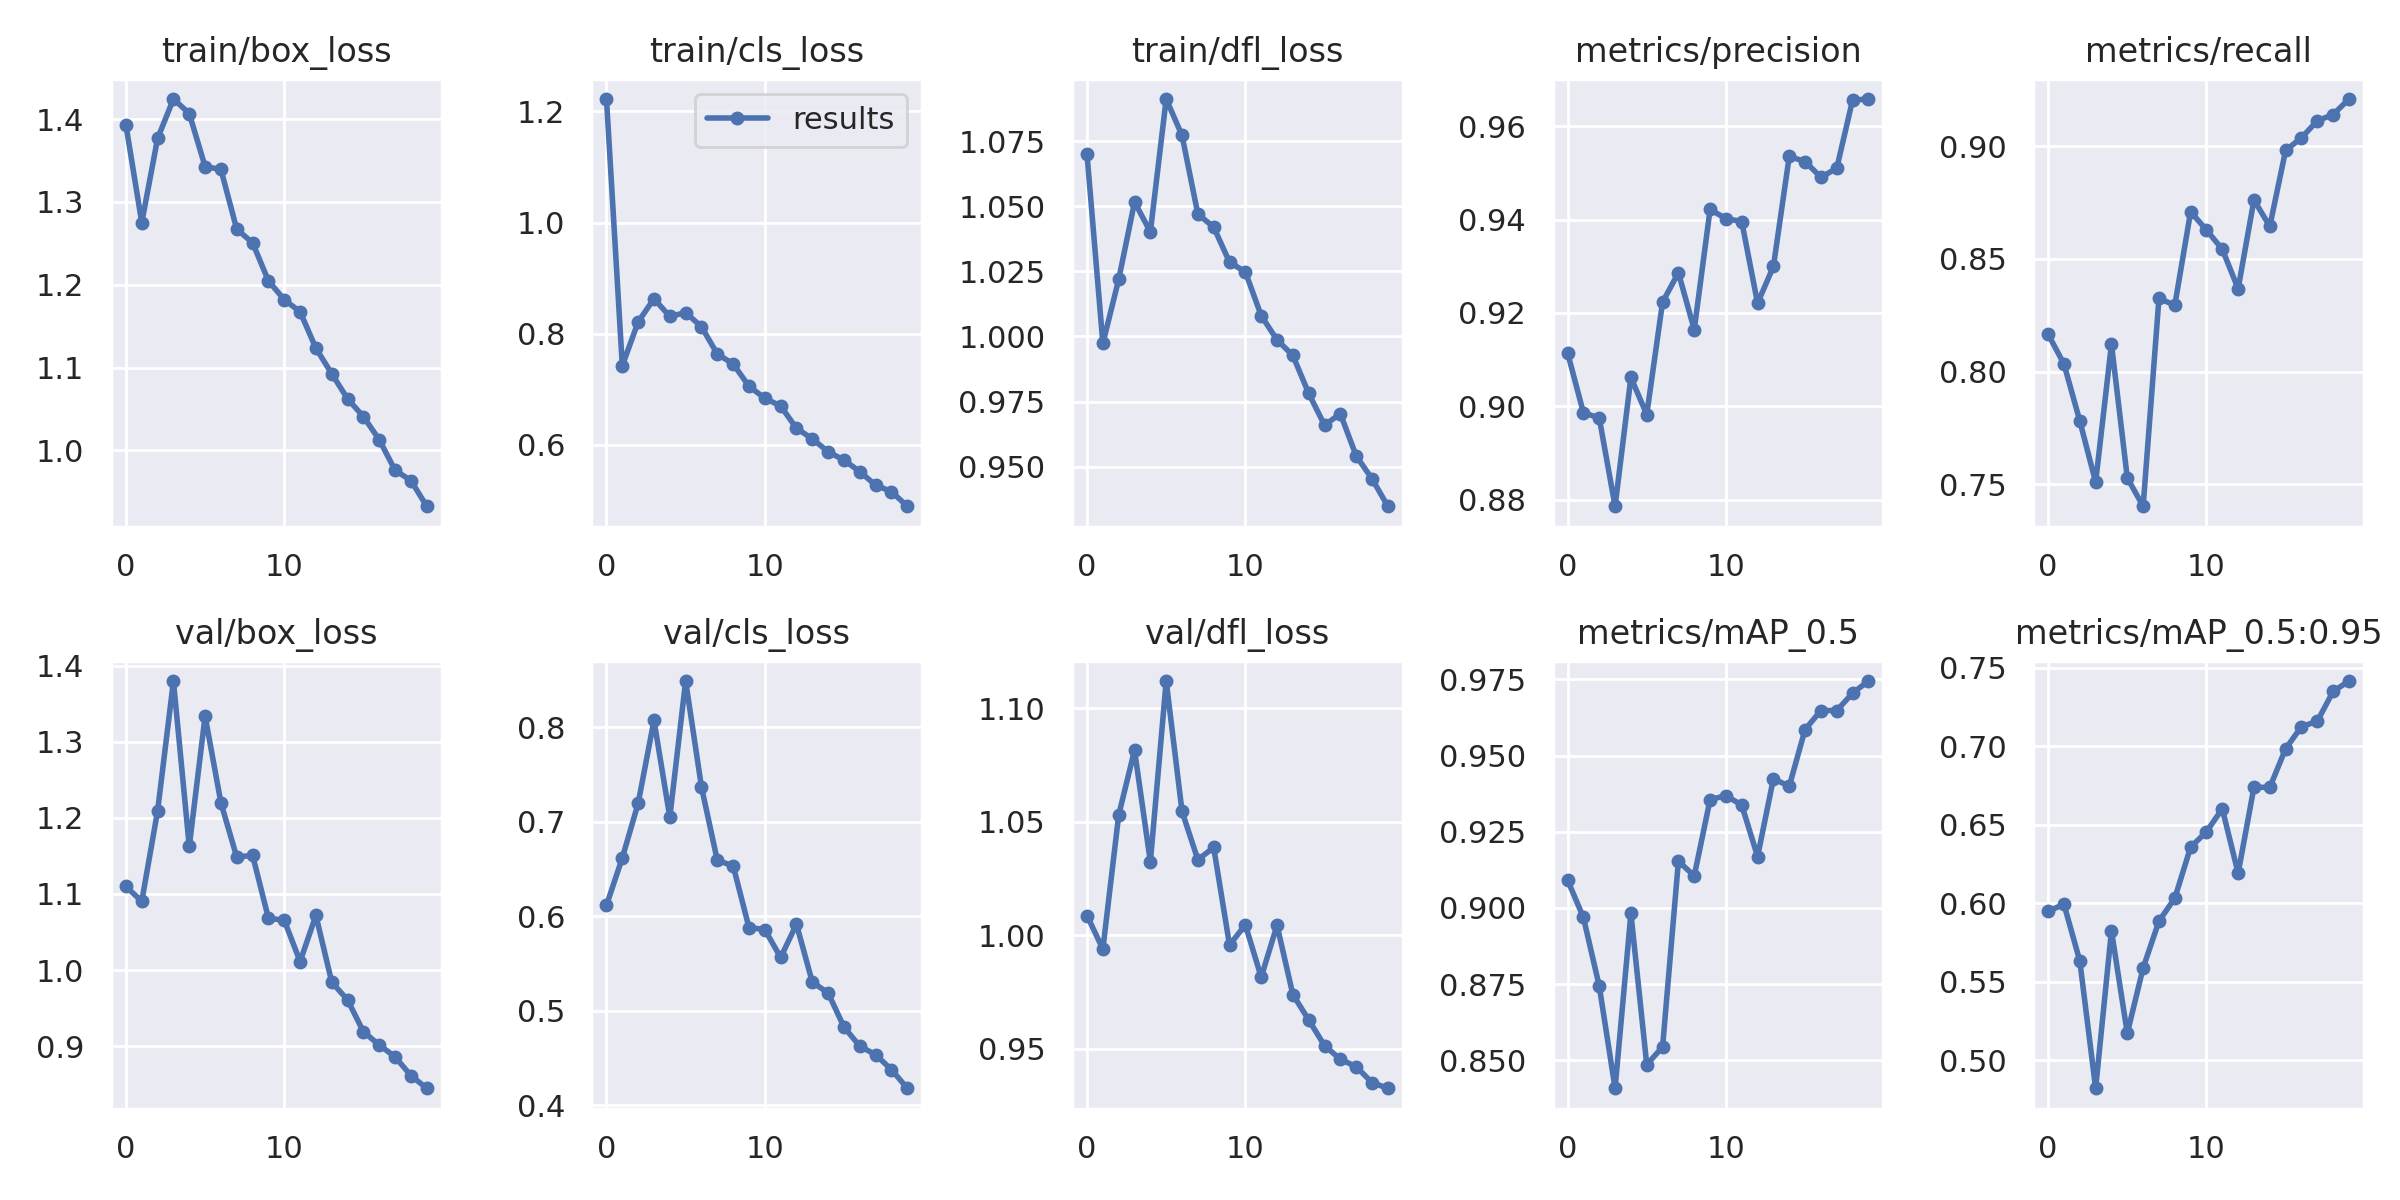

In [10]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

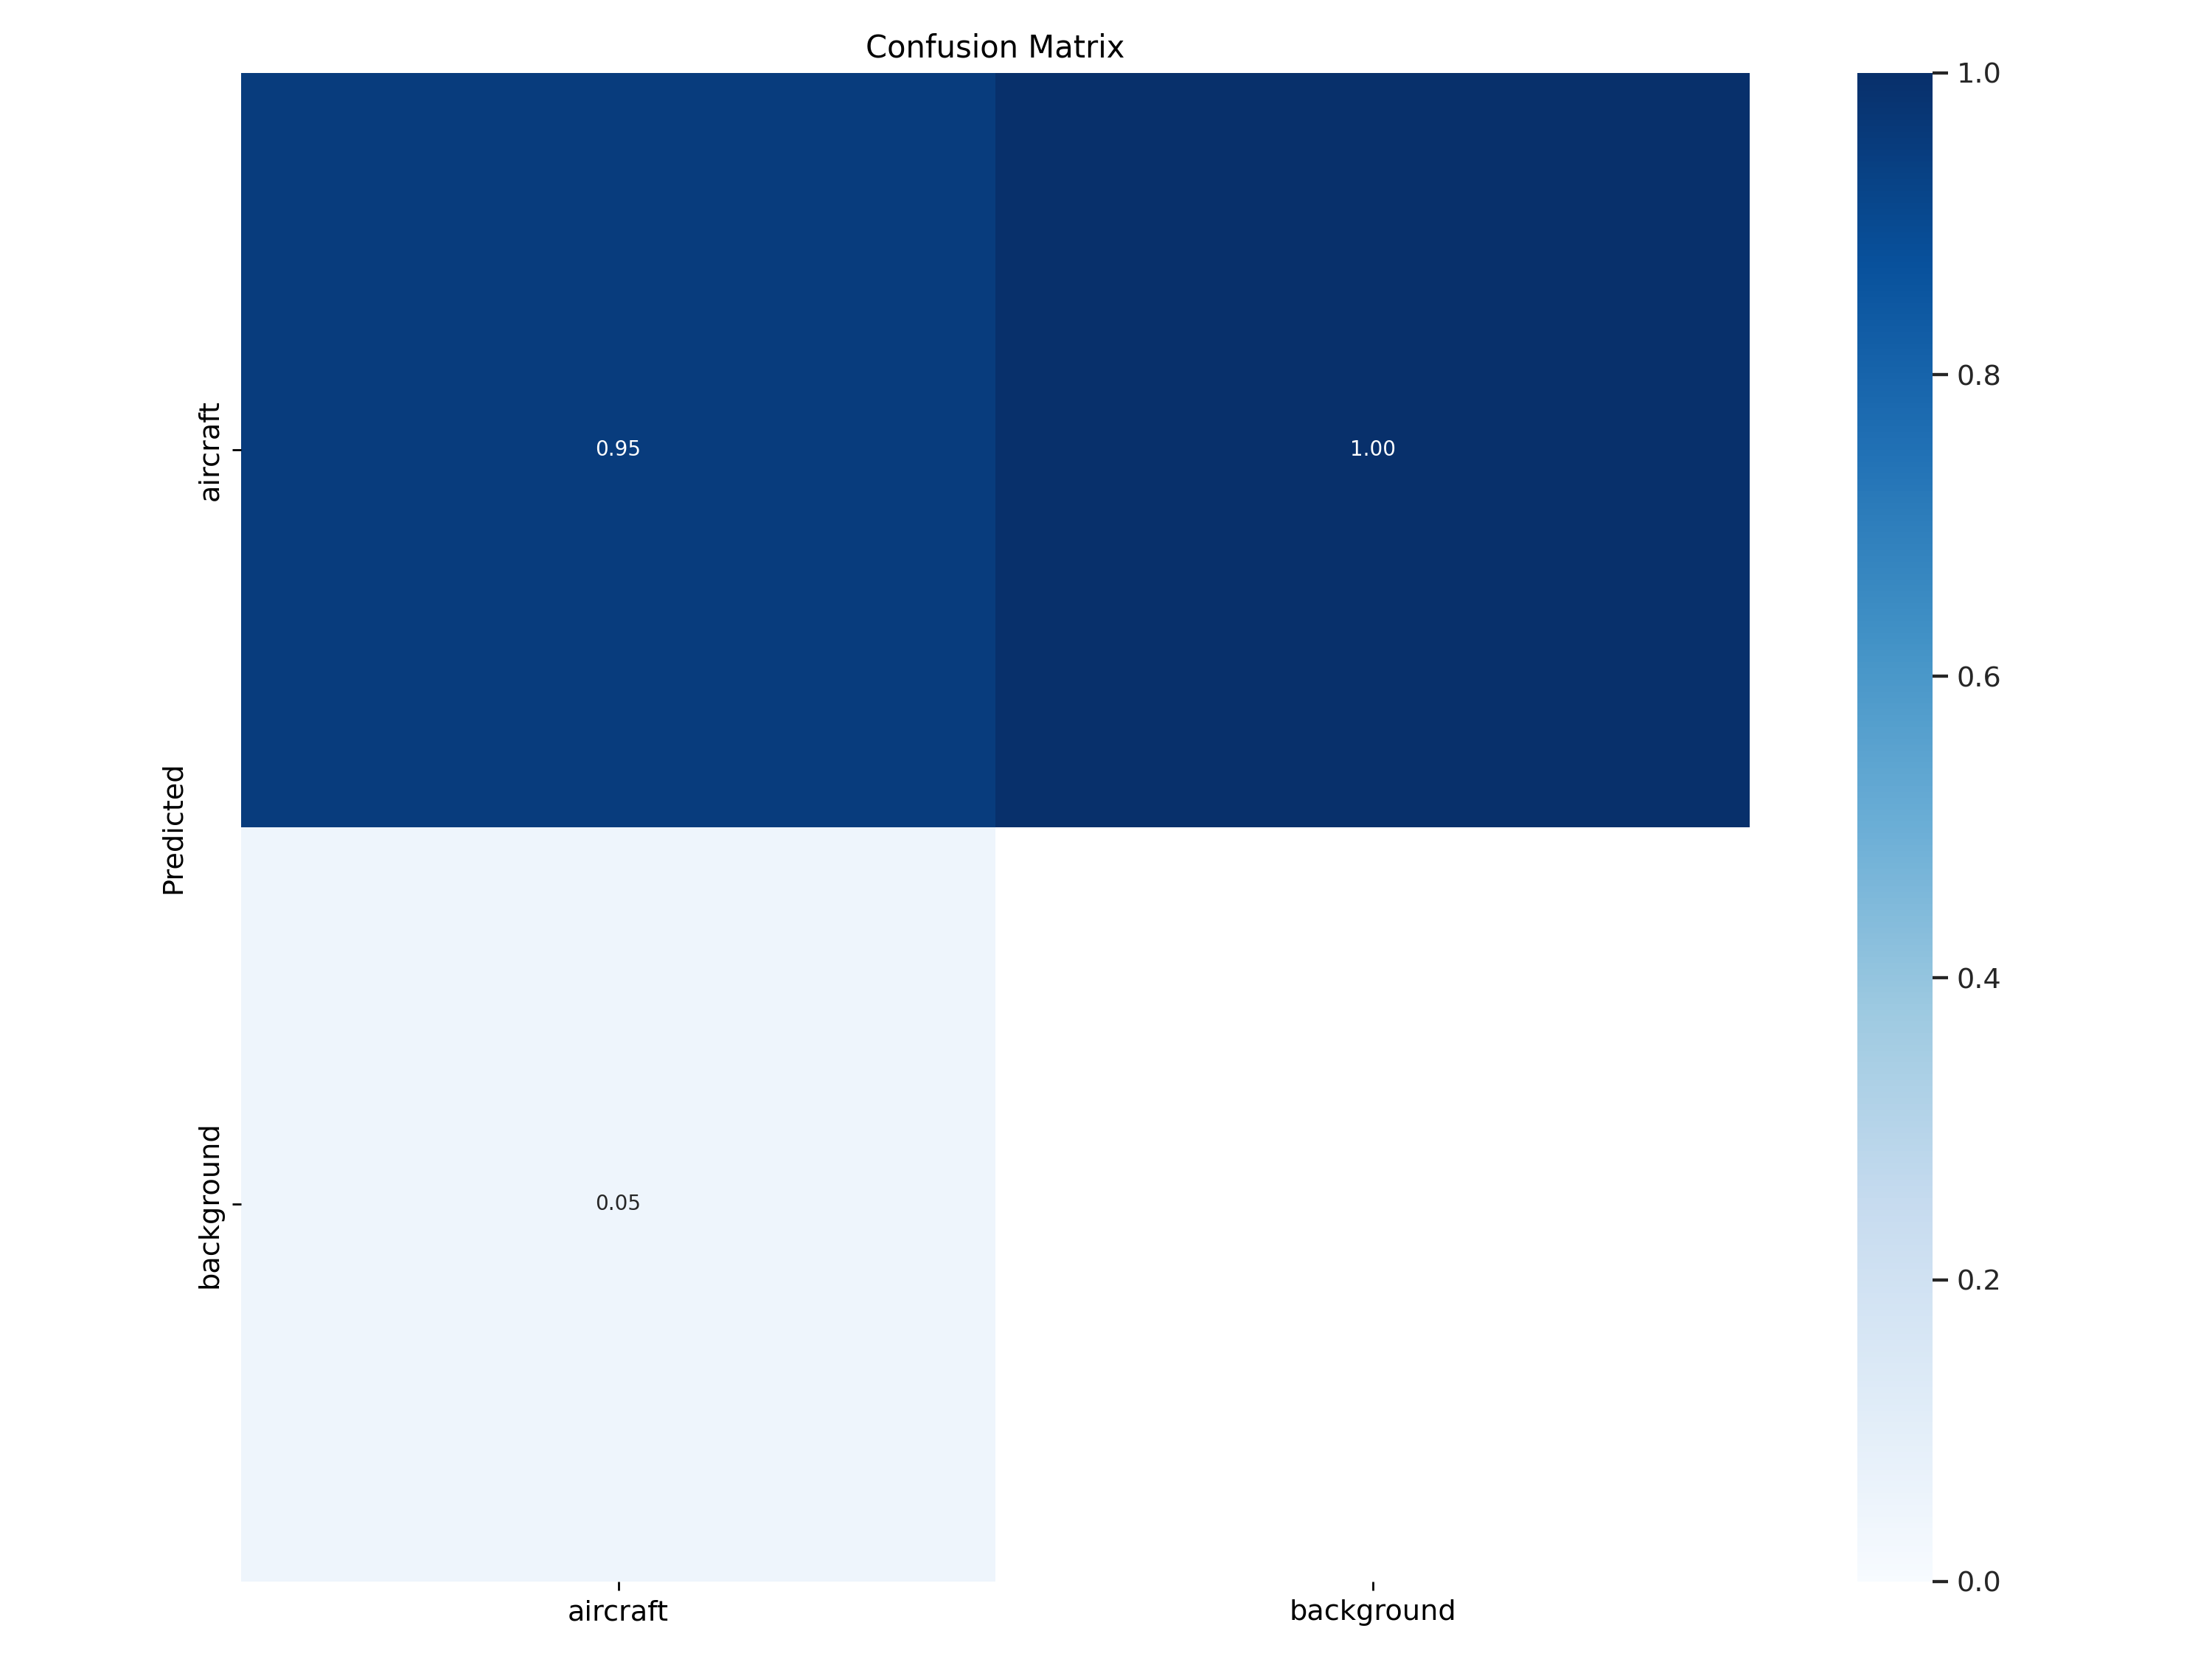

In [11]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

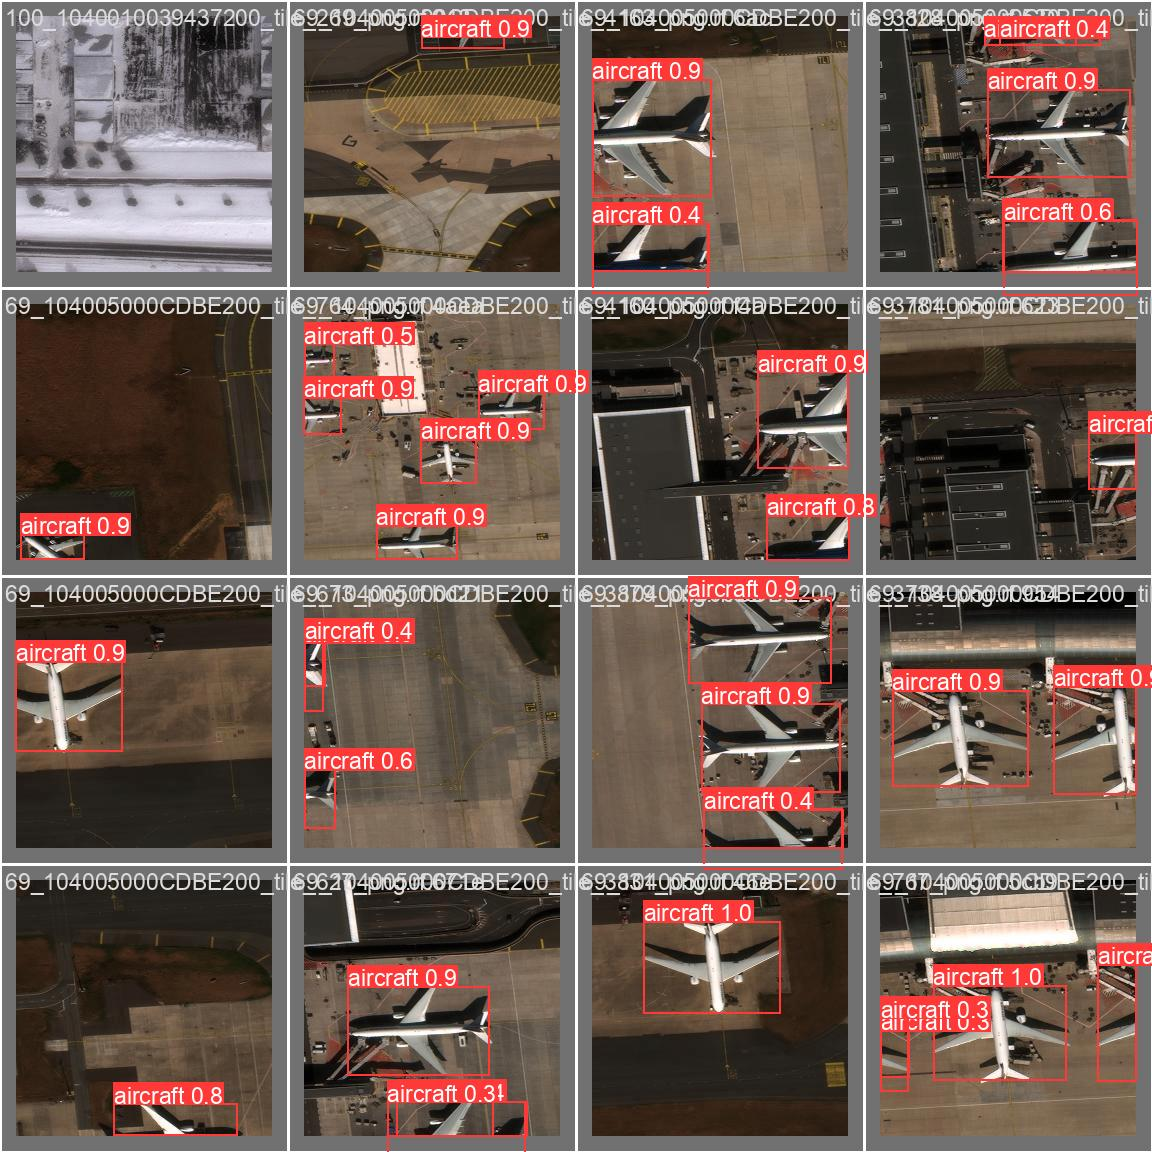

In [12]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [13]:
%cd {HOME}/yolov9

!python val.py \
--img 256 --batch 16 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Aircraft-Object-Detection-4/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=256, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/Aircraft-Object-Detection-4/valid/labels.cache... 1705 images, 0 backgrounds, 0 corrupt: 100% 1705/1705 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
    

## Inference with Custom Model

In [14]:
!python detect.py \
--img 256 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/Aircraft-Object-Detection-4/test/images, data=data/coco128.yaml, imgsz=[256, 256], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25411731 parameters, 0 gradients, 102.5 GFLOPs
image 1/1705 /content/yolov9/Aircraft-Object-Detection-4/test/images/100_1040010029990A00_tile_456_png.rf.0d55ae54eb0728fd7648eef2cb3e8043.jpg: 256x256 3 aircrafts, 16.4ms
image 2/1705 /content/yolov9/Aircraft-Object-Detection-4/test/images/100_1040010029990A00_tile_470_png.rf.7ae157d543712154a766a1

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

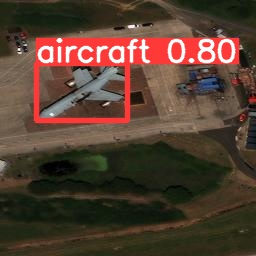

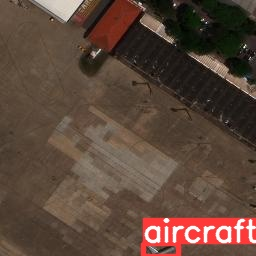

In [15]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

## BONUS: Deploy YOLOv9 Model with Inference

**NOTE:** To deploy the model and display inference results, we will need two additional packages - [`inference`](https://pypi.org/project/inference) and [`supervision`](https://pypi.org/project/supervision). Let's install and import them!

In [16]:
!pip install -q inference supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 940.0/940.0 kB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [17]:
import cv2
import random
import getpass

import supervision as sv

from inference import get_model

%matplotlib inline

**NOTE:** Before using your model in Inference, you first need to upload your weights to Roboflow Universe. Ensure to specify the correct `model_type` - `yolov9`, and that the project version matches the version of the dataset you used for training, denoted by `[1]`. In my case, it's `6`.

![YOLOv9 Benchmark](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/upload-roboflow-model.png)



In [18]:
version.deploy(model_type="yolov9", model_path=f"{HOME}/yolov9/runs/train/exp")

An error occured when getting the model upload URL: This version already has a trained model. Please generate and train a new version in order to upload model to Roboflow.


**NOTE:** Now we can download our model anywhere using the assigned `model_id` denoted by `[2]`. In my case `football-players-detection-3zvbc/6`. To download the model you will need your [`ROBOFLOW_API_KEY`](https://docs.roboflow.com/api-reference/authentication).




In [ ]:
ROBOFLOW_API_KEY = getpass.getpass()

model = get_model(model_id="aircraft-object-detection/4", api_key=ROBOFLOW_API_KEY)

··········


**NOTE:** Let's pick random image from our test subset and detect objects using newly fine-tuned model.

In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=f"{dataset.location}/test/images",
    extensions=['png', 'jpg', 'jpeg']
)
image_path = random.choice(image_paths)
image = cv2.imread(image_path)

result = model.infer(image, confidence=0.1)[0]
detections = sv.Detections.from_inference(result)

**NOTE:** Finally, let's use supervision and [annotate](https://supervision.roboflow.com/develop/annotators/) our results.

In [ ]:
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
bounding_box_annotator = sv.BoundingBoxAnnotator()

annotated_image = image.copy()
annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)